<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:08:57] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


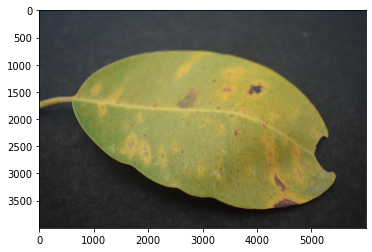

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

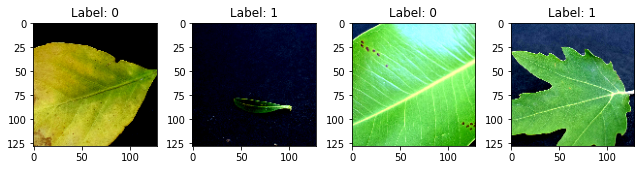

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:03] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:05] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:107: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.264452497685472 samples/sec                   batch loss = 0.4732952415943146 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2647929948694259 samples/sec                   batch loss = 0.5983427166938782 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.259347666757643 samples/sec                   batch loss = 0.5888159275054932 | accuracy = 0.4666666666666667


Epoch[1] Batch[20] Speed: 1.266187111170582 samples/sec                   batch loss = 0.30927574634552 | accuracy = 0.475


Epoch[1] Batch[25] Speed: 1.2694575709491436 samples/sec                   batch loss = 0.4265064597129822 | accuracy = 0.47


Epoch[1] Batch[30] Speed: 1.263155865870641 samples/sec                   batch loss = 0.8823407292366028 | accuracy = 0.475


Epoch[1] Batch[35] Speed: 1.2324274467909588 samples/sec                   batch loss = 0.6619822382926941 | accuracy = 0.4928571428571429


Epoch[1] Batch[40] Speed: 1.267401886778057 samples/sec                   batch loss = 0.42622795701026917 | accuracy = 0.5375


Epoch[1] Batch[45] Speed: 1.2660508573560063 samples/sec                   batch loss = 0.512309193611145 | accuracy = 0.5555555555555556


Epoch[1] Batch[50] Speed: 1.2633630340684194 samples/sec                   batch loss = 0.4551544785499573 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.2632102671011185 samples/sec                   batch loss = 0.9504426717758179 | accuracy = 0.5727272727272728


Epoch[1] Batch[60] Speed: 1.264353966924498 samples/sec                   batch loss = 0.7760173678398132 | accuracy = 0.5875


Epoch[1] Batch[65] Speed: 1.2652926335229677 samples/sec                   batch loss = 0.18127204477787018 | accuracy = 0.5923076923076923


Epoch[1] Batch[70] Speed: 1.2641698108501702 samples/sec                   batch loss = 0.2748761475086212 | accuracy = 0.5964285714285714


Epoch[1] Batch[75] Speed: 1.255336420516798 samples/sec                   batch loss = 0.34442228078842163 | accuracy = 0.6066666666666667


Epoch[1] Batch[80] Speed: 1.2573382319205717 samples/sec                   batch loss = 0.3238805830478668 | accuracy = 0.6125


Epoch[1] Batch[85] Speed: 1.2573906253993234 samples/sec                   batch loss = 0.39788705110549927 | accuracy = 0.6147058823529412


Epoch[1] Batch[90] Speed: 1.2613153612430001 samples/sec                   batch loss = 0.5051863789558411 | accuracy = 0.6166666666666667


Epoch[1] Batch[95] Speed: 1.2641790507197748 samples/sec                   batch loss = 0.6027124524116516 | accuracy = 0.618421052631579


Epoch[1] Batch[100] Speed: 1.265391883283451 samples/sec                   batch loss = 0.3871171176433563 | accuracy = 0.625


Epoch[1] Batch[105] Speed: 1.256934778833422 samples/sec                   batch loss = 0.4388308823108673 | accuracy = 0.6285714285714286


Epoch[1] Batch[110] Speed: 1.2633196543863368 samples/sec                   batch loss = 0.7269322872161865 | accuracy = 0.6318181818181818


Epoch[1] Batch[115] Speed: 1.253661553250003 samples/sec                   batch loss = 0.8748220205307007 | accuracy = 0.6239130434782608


Epoch[1] Batch[120] Speed: 1.2515093334972451 samples/sec                   batch loss = 0.3664347529411316 | accuracy = 0.6333333333333333


Epoch[1] Batch[125] Speed: 1.2601695772676358 samples/sec                   batch loss = 0.498934805393219 | accuracy = 0.632


Epoch[1] Batch[130] Speed: 1.255108777561335 samples/sec                   batch loss = 0.30622971057891846 | accuracy = 0.6326923076923077


Epoch[1] Batch[135] Speed: 1.2565675348981917 samples/sec                   batch loss = 0.9134640693664551 | accuracy = 0.6314814814814815


Epoch[1] Batch[140] Speed: 1.2559663434998645 samples/sec                   batch loss = 0.6949529647827148 | accuracy = 0.6339285714285714


Epoch[1] Batch[145] Speed: 1.2579383797329444 samples/sec                   batch loss = 0.8358420133590698 | accuracy = 0.6344827586206897


Epoch[1] Batch[150] Speed: 1.258755901209829 samples/sec                   batch loss = 0.19459375739097595 | accuracy = 0.635


Epoch[1] Batch[155] Speed: 1.2609116265422802 samples/sec                   batch loss = 0.8934274315834045 | accuracy = 0.6387096774193548


Epoch[1] Batch[160] Speed: 1.2577190321692904 samples/sec                   batch loss = 0.35627520084381104 | accuracy = 0.6421875


Epoch[1] Batch[165] Speed: 1.257945076412225 samples/sec                   batch loss = 0.2772047519683838 | accuracy = 0.6409090909090909


Epoch[1] Batch[170] Speed: 1.2591439867436218 samples/sec                   batch loss = 0.70502108335495 | accuracy = 0.6397058823529411


Epoch[1] Batch[175] Speed: 1.2629618856454943 samples/sec                   batch loss = 0.5616499185562134 | accuracy = 0.64


Epoch[1] Batch[180] Speed: 1.2634225908527483 samples/sec                   batch loss = 0.7428653836250305 | accuracy = 0.6361111111111111


Epoch[1] Batch[185] Speed: 1.2602853495085273 samples/sec                   batch loss = 0.22091776132583618 | accuracy = 0.6418918918918919


Epoch[1] Batch[190] Speed: 1.2547232689125203 samples/sec                   batch loss = 0.513878345489502 | accuracy = 0.6421052631578947


Epoch[1] Batch[195] Speed: 1.2607399351760926 samples/sec                   batch loss = 0.9009946584701538 | accuracy = 0.6410256410256411


Epoch[1] Batch[200] Speed: 1.2554575068612635 samples/sec                   batch loss = 0.8176846504211426 | accuracy = 0.645


Epoch[1] Batch[205] Speed: 1.2570708670290598 samples/sec                   batch loss = 0.8426072001457214 | accuracy = 0.6463414634146342


Epoch[1] Batch[210] Speed: 1.2584476250397925 samples/sec                   batch loss = 0.9613417387008667 | accuracy = 0.6488095238095238


Epoch[1] Batch[215] Speed: 1.2573783747344023 samples/sec                   batch loss = 0.2528301179409027 | accuracy = 0.6476744186046511


Epoch[1] Batch[220] Speed: 1.2572198914999555 samples/sec                   batch loss = 0.5026548504829407 | accuracy = 0.6443181818181818


Epoch[1] Batch[225] Speed: 1.2650661351803447 samples/sec                   batch loss = 0.6295216083526611 | accuracy = 0.6455555555555555


Epoch[1] Batch[230] Speed: 1.2673806321018237 samples/sec                   batch loss = 0.37820184230804443 | accuracy = 0.6489130434782608


Epoch[1] Batch[235] Speed: 1.2663421283739031 samples/sec                   batch loss = 1.4071345329284668 | accuracy = 0.6468085106382979


Epoch[1] Batch[240] Speed: 1.270831190311963 samples/sec                   batch loss = 0.2773854434490204 | accuracy = 0.646875


Epoch[1] Batch[245] Speed: 1.2670082165297245 samples/sec                   batch loss = 0.4844270646572113 | accuracy = 0.6489795918367347


Epoch[1] Batch[250] Speed: 1.2601733634312868 samples/sec                   batch loss = 0.4233044981956482 | accuracy = 0.648


Epoch[1] Batch[255] Speed: 1.2589232739027447 samples/sec                   batch loss = 0.6600955724716187 | accuracy = 0.6519607843137255


Epoch[1] Batch[260] Speed: 1.2551111249427327 samples/sec                   batch loss = 0.24390512704849243 | accuracy = 0.6509615384615385


Epoch[1] Batch[265] Speed: 1.2566478188149448 samples/sec                   batch loss = 0.5147705078125 | accuracy = 0.6518867924528302


Epoch[1] Batch[270] Speed: 1.2567856336501688 samples/sec                   batch loss = 0.47888630628585815 | accuracy = 0.6527777777777778


Epoch[1] Batch[275] Speed: 1.2617557921418527 samples/sec                   batch loss = 0.4672691226005554 | accuracy = 0.6563636363636364


Epoch[1] Batch[280] Speed: 1.257706397967605 samples/sec                   batch loss = 0.6047121286392212 | accuracy = 0.65625


Epoch[1] Batch[285] Speed: 1.258275094078796 samples/sec                   batch loss = 0.6902042031288147 | accuracy = 0.6535087719298246


Epoch[1] Batch[290] Speed: 1.2576130635957825 samples/sec                   batch loss = 0.683820366859436 | accuracy = 0.6525862068965518


Epoch[1] Batch[295] Speed: 1.2581548789188692 samples/sec                   batch loss = 0.606208086013794 | accuracy = 0.6533898305084745


Epoch[1] Batch[300] Speed: 1.2587062269106681 samples/sec                   batch loss = 0.4643835425376892 | accuracy = 0.6558333333333334


Epoch[1] Batch[305] Speed: 1.2551118761066342 samples/sec                   batch loss = 0.4397641718387604 | accuracy = 0.6573770491803279


Epoch[1] Batch[310] Speed: 1.260796497199673 samples/sec                   batch loss = 0.9191277623176575 | accuracy = 0.6580645161290323


Epoch[1] Batch[315] Speed: 1.2632419399056356 samples/sec                   batch loss = 0.861331582069397 | accuracy = 0.6611111111111111


Epoch[1] Batch[320] Speed: 1.2608008556231391 samples/sec                   batch loss = 0.6168062686920166 | accuracy = 0.6609375


Epoch[1] Batch[325] Speed: 1.258020631212742 samples/sec                   batch loss = 0.6696007251739502 | accuracy = 0.6615384615384615


Epoch[1] Batch[330] Speed: 1.2592366033608882 samples/sec                   batch loss = 0.4175416827201843 | accuracy = 0.6628787878787878


Epoch[1] Batch[335] Speed: 1.2561999411479738 samples/sec                   batch loss = 0.7880427241325378 | accuracy = 0.6611940298507463


Epoch[1] Batch[340] Speed: 1.260224668191556 samples/sec                   batch loss = 0.4897798001766205 | accuracy = 0.6610294117647059


Epoch[1] Batch[345] Speed: 1.257213579380434 samples/sec                   batch loss = 0.442443311214447 | accuracy = 0.6644927536231884


Epoch[1] Batch[350] Speed: 1.2618784048353457 samples/sec                   batch loss = 0.715363085269928 | accuracy = 0.665


Epoch[1] Batch[355] Speed: 1.26398932708597 samples/sec                   batch loss = 0.3348143994808197 | accuracy = 0.6661971830985915


Epoch[1] Batch[360] Speed: 1.259264201967255 samples/sec                   batch loss = 0.33949124813079834 | accuracy = 0.6652777777777777


Epoch[1] Batch[365] Speed: 1.2595364722216738 samples/sec                   batch loss = 0.4601803421974182 | accuracy = 0.6657534246575343


Epoch[1] Batch[370] Speed: 1.2633268841264724 samples/sec                   batch loss = 0.3593355715274811 | accuracy = 0.6655405405405406


Epoch[1] Batch[375] Speed: 1.265827621199718 samples/sec                   batch loss = 0.6306101083755493 | accuracy = 0.6646666666666666


Epoch[1] Batch[380] Speed: 1.2655418372093779 samples/sec                   batch loss = 0.3749537467956543 | accuracy = 0.6671052631578948


Epoch[1] Batch[385] Speed: 1.2626296903131426 samples/sec                   batch loss = 0.48001912236213684 | accuracy = 0.6662337662337663


Epoch[1] Batch[390] Speed: 1.262742588604785 samples/sec                   batch loss = 0.5694014430046082 | accuracy = 0.6653846153846154


Epoch[1] Batch[395] Speed: 1.2624288420906733 samples/sec                   batch loss = 0.925109326839447 | accuracy = 0.6639240506329114


Epoch[1] Batch[400] Speed: 1.2603975448670433 samples/sec                   batch loss = 0.6802120804786682 | accuracy = 0.665


Epoch[1] Batch[405] Speed: 1.262404334241718 samples/sec                   batch loss = 0.7667599320411682 | accuracy = 0.6654320987654321


Epoch[1] Batch[410] Speed: 1.2496278425743923 samples/sec                   batch loss = 0.819791316986084 | accuracy = 0.6664634146341464


Epoch[1] Batch[415] Speed: 1.2720127513523443 samples/sec                   batch loss = 0.5105364322662354 | accuracy = 0.6662650602409639


Epoch[1] Batch[420] Speed: 1.2666310471378939 samples/sec                   batch loss = 0.6028738617897034 | accuracy = 0.6666666666666666


Epoch[1] Batch[425] Speed: 1.2664931680680547 samples/sec                   batch loss = 0.818322479724884 | accuracy = 0.6647058823529411


Epoch[1] Batch[430] Speed: 1.2669565493190678 samples/sec                   batch loss = 0.5064243078231812 | accuracy = 0.666860465116279


Epoch[1] Batch[435] Speed: 1.2686401958294888 samples/sec                   batch loss = 0.6954089999198914 | accuracy = 0.6672413793103448


Epoch[1] Batch[440] Speed: 1.265317730789678 samples/sec                   batch loss = 0.3342089056968689 | accuracy = 0.6681818181818182


Epoch[1] Batch[445] Speed: 1.2632523076251208 samples/sec                   batch loss = 0.644119381904602 | accuracy = 0.6685393258426966


Epoch[1] Batch[450] Speed: 1.2629862249927881 samples/sec                   batch loss = 0.4604364037513733 | accuracy = 0.6694444444444444


Epoch[1] Batch[455] Speed: 1.2649062803744744 samples/sec                   batch loss = 0.5093185305595398 | accuracy = 0.6703296703296703


Epoch[1] Batch[460] Speed: 1.2675385273261077 samples/sec                   batch loss = 0.4461989402770996 | accuracy = 0.6684782608695652


Epoch[1] Batch[465] Speed: 1.2707731468496297 samples/sec                   batch loss = 0.45524364709854126 | accuracy = 0.6682795698924732


Epoch[1] Batch[470] Speed: 1.271351315305389 samples/sec                   batch loss = 0.4065052270889282 | accuracy = 0.6712765957446809


Epoch[1] Batch[475] Speed: 1.2644954786785232 samples/sec                   batch loss = 0.4070572257041931 | accuracy = 0.6710526315789473


Epoch[1] Batch[480] Speed: 1.2687021700070782 samples/sec                   batch loss = 0.8259189128875732 | accuracy = 0.6703125


Epoch[1] Batch[485] Speed: 1.2628217624962195 samples/sec                   batch loss = 0.44977664947509766 | accuracy = 0.6721649484536083


Epoch[1] Batch[490] Speed: 1.264281269835385 samples/sec                   batch loss = 0.3533123731613159 | accuracy = 0.6719387755102041


Epoch[1] Batch[495] Speed: 1.2638919158439774 samples/sec                   batch loss = 0.9193405508995056 | accuracy = 0.6707070707070707


Epoch[1] Batch[500] Speed: 1.2632251997269837 samples/sec                   batch loss = 0.4416862428188324 | accuracy = 0.67


Epoch[1] Batch[505] Speed: 1.2679201661175465 samples/sec                   batch loss = 0.4229545295238495 | accuracy = 0.6707920792079208


Epoch[1] Batch[510] Speed: 1.260286864249539 samples/sec                   batch loss = 0.8501512408256531 | accuracy = 0.6700980392156862


Epoch[1] Batch[515] Speed: 1.2647758321691143 samples/sec                   batch loss = 0.36140739917755127 | accuracy = 0.670388349514563


Epoch[1] Batch[520] Speed: 1.2645764929283896 samples/sec                   batch loss = 0.6045622825622559 | accuracy = 0.6706730769230769


Epoch[1] Batch[525] Speed: 1.2710765137752857 samples/sec                   batch loss = 0.41014719009399414 | accuracy = 0.6719047619047619


Epoch[1] Batch[530] Speed: 1.2685247059339457 samples/sec                   batch loss = 0.6749150156974792 | accuracy = 0.6716981132075471


Epoch[1] Batch[535] Speed: 1.2675614153440122 samples/sec                   batch loss = 0.2857806980609894 | accuracy = 0.6728971962616822


Epoch[1] Batch[540] Speed: 1.2699481172657885 samples/sec                   batch loss = 0.36685240268707275 | accuracy = 0.6726851851851852


Epoch[1] Batch[545] Speed: 1.265228129527165 samples/sec                   batch loss = 0.2671343982219696 | accuracy = 0.6743119266055045


Epoch[1] Batch[550] Speed: 1.2639162910512307 samples/sec                   batch loss = 0.398102343082428 | accuracy = 0.6759090909090909


Epoch[1] Batch[555] Speed: 1.2667103268519049 samples/sec                   batch loss = 0.3808678686618805 | accuracy = 0.6761261261261261


Epoch[1] Batch[560] Speed: 1.268754939172087 samples/sec                   batch loss = 0.8961805105209351 | accuracy = 0.6754464285714286


Epoch[1] Batch[565] Speed: 1.2691804189701485 samples/sec                   batch loss = 0.4360284209251404 | accuracy = 0.6752212389380531


Epoch[1] Batch[570] Speed: 1.2720715832632807 samples/sec                   batch loss = 0.6107395887374878 | accuracy = 0.6763157894736842


Epoch[1] Batch[575] Speed: 1.2683216903803305 samples/sec                   batch loss = 0.7760703563690186 | accuracy = 0.6752173913043479


Epoch[1] Batch[580] Speed: 1.2640203723376202 samples/sec                   batch loss = 0.4317939579486847 | accuracy = 0.6762931034482759


Epoch[1] Batch[585] Speed: 1.266656101897725 samples/sec                   batch loss = 0.32868674397468567 | accuracy = 0.6782051282051282


Epoch[1] Batch[590] Speed: 1.2629338395140917 samples/sec                   batch loss = 0.35976624488830566 | accuracy = 0.6788135593220339


Epoch[1] Batch[595] Speed: 1.268539284893908 samples/sec                   batch loss = 0.6899016499519348 | accuracy = 0.6798319327731093


Epoch[1] Batch[600] Speed: 1.2622121990858501 samples/sec                   batch loss = 0.394925057888031 | accuracy = 0.6795833333333333


Epoch[1] Batch[605] Speed: 1.2664489039700326 samples/sec                   batch loss = 0.36361798644065857 | accuracy = 0.6805785123966942


Epoch[1] Batch[610] Speed: 1.2669535833663528 samples/sec                   batch loss = 0.41273462772369385 | accuracy = 0.6815573770491803


Epoch[1] Batch[615] Speed: 1.2665602871386636 samples/sec                   batch loss = 0.391483873128891 | accuracy = 0.6808943089430894


Epoch[1] Batch[620] Speed: 1.2679733493980019 samples/sec                   batch loss = 0.3144076466560364 | accuracy = 0.6814516129032258


Epoch[1] Batch[625] Speed: 1.2649183920626546 samples/sec                   batch loss = 0.5350483655929565 | accuracy = 0.6828


Epoch[1] Batch[630] Speed: 1.2657565689558732 samples/sec                   batch loss = 0.3313129246234894 | accuracy = 0.6833333333333333


Epoch[1] Batch[635] Speed: 1.267595796807093 samples/sec                   batch loss = 0.6206344962120056 | accuracy = 0.6830708661417323


Epoch[1] Batch[640] Speed: 1.2730665697417438 samples/sec                   batch loss = 0.553918719291687 | accuracy = 0.68359375


Epoch[1] Batch[645] Speed: 1.263460744395249 samples/sec                   batch loss = 0.4491991400718689 | accuracy = 0.6848837209302325


Epoch[1] Batch[650] Speed: 1.2664631484501105 samples/sec                   batch loss = 0.645227313041687 | accuracy = 0.6846153846153846


Epoch[1] Batch[655] Speed: 1.2649290734289527 samples/sec                   batch loss = 0.41178736090660095 | accuracy = 0.6854961832061068


Epoch[1] Batch[660] Speed: 1.2694950332034092 samples/sec                   batch loss = 0.6441720724105835 | accuracy = 0.6848484848484848


Epoch[1] Batch[665] Speed: 1.265893045977727 samples/sec                   batch loss = 0.4874134063720703 | accuracy = 0.6849624060150376


Epoch[1] Batch[670] Speed: 1.268022607803019 samples/sec                   batch loss = 0.7969185709953308 | accuracy = 0.6824626865671641


Epoch[1] Batch[675] Speed: 1.2680108199375262 samples/sec                   batch loss = 0.4900361895561218 | accuracy = 0.6818518518518518


Epoch[1] Batch[680] Speed: 1.268032095756391 samples/sec                   batch loss = 0.4129014015197754 | accuracy = 0.68125


Epoch[1] Batch[685] Speed: 1.2651421662300146 samples/sec                   batch loss = 1.0642194747924805 | accuracy = 0.6821167883211678


Epoch[1] Batch[690] Speed: 1.2696815128517935 samples/sec                   batch loss = 0.8401542901992798 | accuracy = 0.6818840579710145


Epoch[1] Batch[695] Speed: 1.2668343826974564 samples/sec                   batch loss = 0.6504599452018738 | accuracy = 0.6827338129496403


Epoch[1] Batch[700] Speed: 1.2625149120754757 samples/sec                   batch loss = 0.6140223145484924 | accuracy = 0.6839285714285714


Epoch[1] Batch[705] Speed: 1.2679193995443196 samples/sec                   batch loss = 0.6351934671401978 | accuracy = 0.6829787234042554


Epoch[1] Batch[710] Speed: 1.2649527256677295 samples/sec                   batch loss = 0.5716065764427185 | accuracy = 0.6838028169014084


Epoch[1] Batch[715] Speed: 1.2704710791890779 samples/sec                   batch loss = 0.45258596539497375 | accuracy = 0.6846153846153846


Epoch[1] Batch[720] Speed: 1.2679509256330699 samples/sec                   batch loss = 0.430147260427475 | accuracy = 0.6857638888888888


Epoch[1] Batch[725] Speed: 1.2676325745870178 samples/sec                   batch loss = 1.0584830045700073 | accuracy = 0.6851724137931035


Epoch[1] Batch[730] Speed: 1.268732008031998 samples/sec                   batch loss = 0.7261975407600403 | accuracy = 0.6852739726027397


Epoch[1] Batch[735] Speed: 1.2657400485421695 samples/sec                   batch loss = 0.5629109740257263 | accuracy = 0.6857142857142857


Epoch[1] Batch[740] Speed: 1.2674009293448754 samples/sec                   batch loss = 0.9518939852714539 | accuracy = 0.6868243243243243


Epoch[1] Batch[745] Speed: 1.2705251501975092 samples/sec                   batch loss = 0.4765458106994629 | accuracy = 0.6875838926174497


Epoch[1] Batch[750] Speed: 1.2627647334830738 samples/sec                   batch loss = 0.2128095030784607 | accuracy = 0.6873333333333334


Epoch[1] Batch[755] Speed: 1.2595170879817326 samples/sec                   batch loss = 0.46189576387405396 | accuracy = 0.6874172185430464


Epoch[1] Batch[760] Speed: 1.2663380183035078 samples/sec                   batch loss = 0.48692944645881653 | accuracy = 0.687171052631579


Epoch[1] Batch[765] Speed: 1.2638337428793975 samples/sec                   batch loss = 0.2284785658121109 | accuracy = 0.6879084967320261


Epoch[1] Batch[770] Speed: 1.2643410085086635 samples/sec                   batch loss = 0.2940012216567993 | accuracy = 0.6892857142857143


Epoch[1] Batch[775] Speed: 1.2634404780121864 samples/sec                   batch loss = 0.553349494934082 | accuracy = 0.6896774193548387


Epoch[1] Batch[780] Speed: 1.265170501342525 samples/sec                   batch loss = 0.39866405725479126 | accuracy = 0.6903846153846154


Epoch[1] Batch[785] Speed: 1.2691002537713965 samples/sec                   batch loss = 0.5138988494873047 | accuracy = 0.6920382165605096


[Epoch 1] training: accuracy=0.692258883248731
[Epoch 1] time cost: 650.5252683162689
[Epoch 1] validation: validation accuracy=0.75


Epoch[2] Batch[5] Speed: 1.2674778158352833 samples/sec                   batch loss = 0.42791905999183655 | accuracy = 1.0


Epoch[2] Batch[10] Speed: 1.2633837736532187 samples/sec                   batch loss = 0.386403888463974 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2619520598279579 samples/sec                   batch loss = 0.37126845121383667 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.2614547708835295 samples/sec                   batch loss = 1.4133437871932983 | accuracy = 0.8


Epoch[2] Batch[25] Speed: 1.2670990270795597 samples/sec                   batch loss = 0.5388177037239075 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.2610770137040483 samples/sec                   batch loss = 0.5081930756568909 | accuracy = 0.7666666666666667


Epoch[2] Batch[35] Speed: 1.2692113356807804 samples/sec                   batch loss = 0.39172208309173584 | accuracy = 0.7857142857142857


Epoch[2] Batch[40] Speed: 1.2618829605648036 samples/sec                   batch loss = 0.9021961688995361 | accuracy = 0.7875


Epoch[2] Batch[45] Speed: 1.2710479135028825 samples/sec                   batch loss = 0.39000383019447327 | accuracy = 0.7888888888888889


Epoch[2] Batch[50] Speed: 1.263042988756224 samples/sec                   batch loss = 0.39175260066986084 | accuracy = 0.79


Epoch[2] Batch[55] Speed: 1.2726151194772766 samples/sec                   batch loss = 0.3559485077857971 | accuracy = 0.7909090909090909


Epoch[2] Batch[60] Speed: 1.2598459443838155 samples/sec                   batch loss = 1.0544031858444214 | accuracy = 0.775


Epoch[2] Batch[65] Speed: 1.259877637921671 samples/sec                   batch loss = 0.13867956399917603 | accuracy = 0.7807692307692308


Epoch[2] Batch[70] Speed: 1.2576585034483778 samples/sec                   batch loss = 0.37348368763923645 | accuracy = 0.7785714285714286


Epoch[2] Batch[75] Speed: 1.2642602149659294 samples/sec                   batch loss = 0.3571026623249054 | accuracy = 0.7766666666666666


Epoch[2] Batch[80] Speed: 1.2550881209836406 samples/sec                   batch loss = 0.28402572870254517 | accuracy = 0.778125


Epoch[2] Batch[85] Speed: 1.2611064941375125 samples/sec                   batch loss = 0.5221238732337952 | accuracy = 0.7794117647058824


Epoch[2] Batch[90] Speed: 1.2721398736823908 samples/sec                   batch loss = 0.5820140838623047 | accuracy = 0.7861111111111111


Epoch[2] Batch[95] Speed: 1.2653453103031436 samples/sec                   batch loss = 0.7187362313270569 | accuracy = 0.781578947368421


Epoch[2] Batch[100] Speed: 1.2633708351167539 samples/sec                   batch loss = 0.21536307036876678 | accuracy = 0.78


Epoch[2] Batch[105] Speed: 1.2647124295651992 samples/sec                   batch loss = 0.6912088990211487 | accuracy = 0.7785714285714286


Epoch[2] Batch[110] Speed: 1.258970981381397 samples/sec                   batch loss = 0.271820068359375 | accuracy = 0.7772727272727272


Epoch[2] Batch[115] Speed: 1.259937528870537 samples/sec                   batch loss = 0.26012200117111206 | accuracy = 0.7760869565217391


Epoch[2] Batch[120] Speed: 1.2623657695535322 samples/sec                   batch loss = 0.29118120670318604 | accuracy = 0.78125


Epoch[2] Batch[125] Speed: 1.259488060016232 samples/sec                   batch loss = 0.7071149349212646 | accuracy = 0.774


Epoch[2] Batch[130] Speed: 1.2599406513036542 samples/sec                   batch loss = 0.5839542150497437 | accuracy = 0.7788461538461539


Epoch[2] Batch[135] Speed: 1.2666302821226538 samples/sec                   batch loss = 0.2237093597650528 | accuracy = 0.7814814814814814


Epoch[2] Batch[140] Speed: 1.2634816774922641 samples/sec                   batch loss = 0.19390033185482025 | accuracy = 0.7821428571428571


Epoch[2] Batch[145] Speed: 1.2565448539619637 samples/sec                   batch loss = 0.536034345626831 | accuracy = 0.7844827586206896


Epoch[2] Batch[150] Speed: 1.25728659657717 samples/sec                   batch loss = 0.5301930904388428 | accuracy = 0.785


Epoch[2] Batch[155] Speed: 1.2573358762012623 samples/sec                   batch loss = 0.3096112012863159 | accuracy = 0.7870967741935484


Epoch[2] Batch[160] Speed: 1.2635439099767622 samples/sec                   batch loss = 0.17727918922901154 | accuracy = 0.7875


Epoch[2] Batch[165] Speed: 1.257659729050044 samples/sec                   batch loss = 0.3830759525299072 | accuracy = 0.7863636363636364


Epoch[2] Batch[170] Speed: 1.2608693626292362 samples/sec                   batch loss = 0.6985234618186951 | accuracy = 0.7823529411764706


Epoch[2] Batch[175] Speed: 1.2597202266250835 samples/sec                   batch loss = 0.5641657114028931 | accuracy = 0.7814285714285715


Epoch[2] Batch[180] Speed: 1.2617074938383788 samples/sec                   batch loss = 0.4976421594619751 | accuracy = 0.7833333333333333


Epoch[2] Batch[185] Speed: 1.2624904958874208 samples/sec                   batch loss = 0.32152512669563293 | accuracy = 0.7837837837837838


Epoch[2] Batch[190] Speed: 1.2641548558835303 samples/sec                   batch loss = 0.3446071147918701 | accuracy = 0.7828947368421053


Epoch[2] Batch[195] Speed: 1.2620496469511027 samples/sec                   batch loss = 0.5113803148269653 | accuracy = 0.7833333333333333


Epoch[2] Batch[200] Speed: 1.2611345539653702 samples/sec                   batch loss = 0.3482435941696167 | accuracy = 0.7875


Epoch[2] Batch[205] Speed: 1.2625224176304466 samples/sec                   batch loss = 1.1580779552459717 | accuracy = 0.7853658536585366


Epoch[2] Batch[210] Speed: 1.2631824952581385 samples/sec                   batch loss = 0.2719426453113556 | accuracy = 0.7857142857142857


Epoch[2] Batch[215] Speed: 1.2605247237580268 samples/sec                   batch loss = 0.635175883769989 | accuracy = 0.7837209302325582


Epoch[2] Batch[220] Speed: 1.264900939861245 samples/sec                   batch loss = 0.49489516019821167 | accuracy = 0.7840909090909091


Epoch[2] Batch[225] Speed: 1.264859647772373 samples/sec                   batch loss = 0.39577966928482056 | accuracy = 0.7811111111111111


Epoch[2] Batch[230] Speed: 1.2623658645375544 samples/sec                   batch loss = 0.6570116877555847 | accuracy = 0.7782608695652173


Epoch[2] Batch[235] Speed: 1.257374322643928 samples/sec                   batch loss = 0.16812150180339813 | accuracy = 0.7787234042553192


Epoch[2] Batch[240] Speed: 1.2651807099263863 samples/sec                   batch loss = 0.29164186120033264 | accuracy = 0.7791666666666667


Epoch[2] Batch[245] Speed: 1.2580718551720507 samples/sec                   batch loss = 0.3288654088973999 | accuracy = 0.7806122448979592


Epoch[2] Batch[250] Speed: 1.262810546383397 samples/sec                   batch loss = 0.17239637672901154 | accuracy = 0.782


Epoch[2] Batch[255] Speed: 1.2559275130223042 samples/sec                   batch loss = 0.3460640013217926 | accuracy = 0.7813725490196078


Epoch[2] Batch[260] Speed: 1.2648797689846758 samples/sec                   batch loss = 0.33449169993400574 | accuracy = 0.7836538461538461


Epoch[2] Batch[265] Speed: 1.2657773872011235 samples/sec                   batch loss = 0.729595959186554 | accuracy = 0.7830188679245284


Epoch[2] Batch[270] Speed: 1.264451163510717 samples/sec                   batch loss = 0.13237939774990082 | accuracy = 0.7833333333333333


Epoch[2] Batch[275] Speed: 1.261633487895295 samples/sec                   batch loss = 0.7638039588928223 | accuracy = 0.7809090909090909


Epoch[2] Batch[280] Speed: 1.2655981626319095 samples/sec                   batch loss = 0.34289929270744324 | accuracy = 0.7776785714285714


Epoch[2] Batch[285] Speed: 1.2610728429501583 samples/sec                   batch loss = 0.461211621761322 | accuracy = 0.7789473684210526


Epoch[2] Batch[290] Speed: 1.2613234215052986 samples/sec                   batch loss = 0.5087273716926575 | accuracy = 0.778448275862069


Epoch[2] Batch[295] Speed: 1.2632840776601362 samples/sec                   batch loss = 0.31841620802879333 | accuracy = 0.7796610169491526


Epoch[2] Batch[300] Speed: 1.2589699421700724 samples/sec                   batch loss = 0.955174446105957 | accuracy = 0.7775


Epoch[2] Batch[305] Speed: 1.2629317479881013 samples/sec                   batch loss = 0.5006257891654968 | accuracy = 0.7754098360655738


Epoch[2] Batch[310] Speed: 1.2585124779564367 samples/sec                   batch loss = 1.1123069524765015 | accuracy = 0.7733870967741936


Epoch[2] Batch[315] Speed: 1.2642170594389879 samples/sec                   batch loss = 0.38770994544029236 | accuracy = 0.7746031746031746


Epoch[2] Batch[320] Speed: 1.2663888703537027 samples/sec                   batch loss = 0.2218925505876541 | accuracy = 0.7765625


Epoch[2] Batch[325] Speed: 1.2605347627975652 samples/sec                   batch loss = 0.5064378976821899 | accuracy = 0.7730769230769231


Epoch[2] Batch[330] Speed: 1.25965222273536 samples/sec                   batch loss = 0.9152466058731079 | accuracy = 0.7712121212121212


Epoch[2] Batch[335] Speed: 1.2648400993403495 samples/sec                   batch loss = 0.4005206823348999 | accuracy = 0.7708955223880597


Epoch[2] Batch[340] Speed: 1.2630300571988586 samples/sec                   batch loss = 1.3415652513504028 | accuracy = 0.7727941176470589


Epoch[2] Batch[345] Speed: 1.2555796501874552 samples/sec                   batch loss = 0.3942008912563324 | accuracy = 0.7724637681159421


Epoch[2] Batch[350] Speed: 1.25823970654001 samples/sec                   batch loss = 0.4176880717277527 | accuracy = 0.7707142857142857


Epoch[2] Batch[355] Speed: 1.259743968237771 samples/sec                   batch loss = 0.6101936101913452 | accuracy = 0.7711267605633803


Epoch[2] Batch[360] Speed: 1.2566230642977214 samples/sec                   batch loss = 0.34743818640708923 | accuracy = 0.7708333333333334


Epoch[2] Batch[365] Speed: 1.2650962793965017 samples/sec                   batch loss = 1.0885730981826782 | accuracy = 0.7678082191780822


Epoch[2] Batch[370] Speed: 1.2620339826314404 samples/sec                   batch loss = 0.06369030475616455 | accuracy = 0.7668918918918919


Epoch[2] Batch[375] Speed: 1.2597525759757606 samples/sec                   batch loss = 0.7124541997909546 | accuracy = 0.7666666666666667


Epoch[2] Batch[380] Speed: 1.264664857951102 samples/sec                   batch loss = 0.2536579668521881 | accuracy = 0.7677631578947368


Epoch[2] Batch[385] Speed: 1.2593796188355786 samples/sec                   batch loss = 0.3340490460395813 | accuracy = 0.7694805194805194


Epoch[2] Batch[390] Speed: 1.2645642924715563 samples/sec                   batch loss = 0.6703730225563049 | accuracy = 0.7685897435897436


Epoch[2] Batch[395] Speed: 1.2592731812267206 samples/sec                   batch loss = 0.5460718870162964 | accuracy = 0.7670886075949367


Epoch[2] Batch[400] Speed: 1.2617786615872275 samples/sec                   batch loss = 0.38406842947006226 | accuracy = 0.76875


Epoch[2] Batch[405] Speed: 1.2606630113896284 samples/sec                   batch loss = 0.7937547564506531 | accuracy = 0.7660493827160494


Epoch[2] Batch[410] Speed: 1.2600111467155455 samples/sec                   batch loss = 0.600925862789154 | accuracy = 0.7646341463414634


Epoch[2] Batch[415] Speed: 1.2638097516616056 samples/sec                   batch loss = 0.3301437795162201 | accuracy = 0.7632530120481927


Epoch[2] Batch[420] Speed: 1.263956474109341 samples/sec                   batch loss = 0.5137360095977783 | accuracy = 0.7619047619047619


Epoch[2] Batch[425] Speed: 1.2601048373898343 samples/sec                   batch loss = 0.983851969242096 | accuracy = 0.7617647058823529


Epoch[2] Batch[430] Speed: 1.2637835718084904 samples/sec                   batch loss = 0.30577442049980164 | accuracy = 0.7627906976744186


Epoch[2] Batch[435] Speed: 1.2565234913392966 samples/sec                   batch loss = 0.5093515515327454 | accuracy = 0.7632183908045977


Epoch[2] Batch[440] Speed: 1.2538481889424824 samples/sec                   batch loss = 0.9545708298683167 | accuracy = 0.7607954545454545


Epoch[2] Batch[445] Speed: 1.2580497802471706 samples/sec                   batch loss = 0.3064762353897095 | accuracy = 0.7617977528089888


Epoch[2] Batch[450] Speed: 1.2589620064310767 samples/sec                   batch loss = 0.36322128772735596 | accuracy = 0.7627777777777778


Epoch[2] Batch[455] Speed: 1.2579828998408216 samples/sec                   batch loss = 0.3322475552558899 | accuracy = 0.7637362637362637


Epoch[2] Batch[460] Speed: 1.2530905608996263 samples/sec                   batch loss = 0.3927731513977051 | accuracy = 0.7614130434782609


Epoch[2] Batch[465] Speed: 1.2576156088949018 samples/sec                   batch loss = 1.0317531824111938 | accuracy = 0.760752688172043


Epoch[2] Batch[470] Speed: 1.2620279068787796 samples/sec                   batch loss = 0.5263283252716064 | accuracy = 0.7595744680851064


Epoch[2] Batch[475] Speed: 1.2555562532025553 samples/sec                   batch loss = 0.437238872051239 | accuracy = 0.7594736842105263


Epoch[2] Batch[480] Speed: 1.2533773965855561 samples/sec                   batch loss = 0.5961422920227051 | accuracy = 0.7583333333333333


Epoch[2] Batch[485] Speed: 1.2592905729987318 samples/sec                   batch loss = 0.8439854383468628 | accuracy = 0.7577319587628866


Epoch[2] Batch[490] Speed: 1.255612351049037 samples/sec                   batch loss = 0.4444677233695984 | accuracy = 0.7576530612244898


Epoch[2] Batch[495] Speed: 1.256310469506015 samples/sec                   batch loss = 0.45804429054260254 | accuracy = 0.7580808080808081


Epoch[2] Batch[500] Speed: 1.2563452782072169 samples/sec                   batch loss = 0.48052099347114563 | accuracy = 0.758


Epoch[2] Batch[505] Speed: 1.2594368152130382 samples/sec                   batch loss = 0.3550386428833008 | accuracy = 0.7589108910891089


Epoch[2] Batch[510] Speed: 1.258779417597115 samples/sec                   batch loss = 0.6796740293502808 | accuracy = 0.7588235294117647


Epoch[2] Batch[515] Speed: 1.2621914979478086 samples/sec                   batch loss = 0.5149243474006653 | accuracy = 0.7582524271844661


Epoch[2] Batch[520] Speed: 1.26434424808772 samples/sec                   batch loss = 0.5701192021369934 | accuracy = 0.7586538461538461


Epoch[2] Batch[525] Speed: 1.256954648698173 samples/sec                   batch loss = 0.35227036476135254 | accuracy = 0.7595238095238095


Epoch[2] Batch[530] Speed: 1.2626399529599859 samples/sec                   batch loss = 0.5159302353858948 | accuracy = 0.7594339622641509


Epoch[2] Batch[535] Speed: 1.2582217776134201 samples/sec                   batch loss = 0.5015221834182739 | accuracy = 0.7602803738317757


Epoch[2] Batch[540] Speed: 1.2578288849933208 samples/sec                   batch loss = 0.49760058522224426 | accuracy = 0.7606481481481482


Epoch[2] Batch[545] Speed: 1.2590119843610468 samples/sec                   batch loss = 0.22139140963554382 | accuracy = 0.7596330275229358


Epoch[2] Batch[550] Speed: 1.256619487680052 samples/sec                   batch loss = 0.4696328639984131 | accuracy = 0.7609090909090909


Epoch[2] Batch[555] Speed: 1.255187936106168 samples/sec                   batch loss = 0.2883109152317047 | accuracy = 0.7621621621621621


Epoch[2] Batch[560] Speed: 1.25891146567914 samples/sec                   batch loss = 0.22868509590625763 | accuracy = 0.7625


Epoch[2] Batch[565] Speed: 1.2567159693681955 samples/sec                   batch loss = 1.115248680114746 | accuracy = 0.7623893805309735


Epoch[2] Batch[570] Speed: 1.2585257892071082 samples/sec                   batch loss = 0.29146748781204224 | accuracy = 0.7631578947368421


Epoch[2] Batch[575] Speed: 1.2582466895233582 samples/sec                   batch loss = 0.5840451121330261 | accuracy = 0.7613043478260869


Epoch[2] Batch[580] Speed: 1.2573156173795847 samples/sec                   batch loss = 0.5112199783325195 | accuracy = 0.7625


Epoch[2] Batch[585] Speed: 1.2497105933378478 samples/sec                   batch loss = 0.29708221554756165 | accuracy = 0.7636752136752136


Epoch[2] Batch[590] Speed: 1.261935638575816 samples/sec                   batch loss = 0.3950842618942261 | accuracy = 0.7627118644067796


Epoch[2] Batch[595] Speed: 1.2554179563088448 samples/sec                   batch loss = 0.6211450099945068 | accuracy = 0.7630252100840336


Epoch[2] Batch[600] Speed: 1.2604348530654799 samples/sec                   batch loss = 0.3319496214389801 | accuracy = 0.7633333333333333


Epoch[2] Batch[605] Speed: 1.2566520544764423 samples/sec                   batch loss = 0.5607537627220154 | accuracy = 0.7636363636363637


Epoch[2] Batch[610] Speed: 1.262737646506201 samples/sec                   batch loss = 0.4199456572532654 | accuracy = 0.7639344262295082


Epoch[2] Batch[615] Speed: 1.25394199623172 samples/sec                   batch loss = 0.36545494198799133 | accuracy = 0.7642276422764228


Epoch[2] Batch[620] Speed: 1.2551056790313346 samples/sec                   batch loss = 0.37769559025764465 | accuracy = 0.7645161290322581


Epoch[2] Batch[625] Speed: 1.2562032332010158 samples/sec                   batch loss = 0.5646435022354126 | accuracy = 0.7652


Epoch[2] Batch[630] Speed: 1.2592711963267613 samples/sec                   batch loss = 1.1303759813308716 | accuracy = 0.7646825396825396


Epoch[2] Batch[635] Speed: 1.2550305678332407 samples/sec                   batch loss = 0.5978043079376221 | accuracy = 0.7641732283464567


Epoch[2] Batch[640] Speed: 1.2565920048762063 samples/sec                   batch loss = 0.5192605257034302 | accuracy = 0.762890625


Epoch[2] Batch[645] Speed: 1.2541678097833846 samples/sec                   batch loss = 0.15520219504833221 | accuracy = 0.7643410852713178


Epoch[2] Batch[650] Speed: 1.2622704128060902 samples/sec                   batch loss = 0.47865554690361023 | accuracy = 0.7638461538461538


Epoch[2] Batch[655] Speed: 1.2567186051734163 samples/sec                   batch loss = 0.1854252964258194 | accuracy = 0.7641221374045801


Epoch[2] Batch[660] Speed: 1.2589646516662927 samples/sec                   batch loss = 0.11682094633579254 | accuracy = 0.7643939393939394


Epoch[2] Batch[665] Speed: 1.262597953183257 samples/sec                   batch loss = 0.4666540026664734 | accuracy = 0.7650375939849624


Epoch[2] Batch[670] Speed: 1.253492767013235 samples/sec                   batch loss = 0.3833560049533844 | accuracy = 0.7649253731343284


Epoch[2] Batch[675] Speed: 1.2569262095595735 samples/sec                   batch loss = 0.5318925976753235 | accuracy = 0.7651851851851852


Epoch[2] Batch[680] Speed: 1.2621936819807902 samples/sec                   batch loss = 0.7892358303070068 | accuracy = 0.7650735294117647


Epoch[2] Batch[685] Speed: 1.2531083438896724 samples/sec                   batch loss = 0.17065320909023285 | accuracy = 0.766058394160584


Epoch[2] Batch[690] Speed: 1.2553014798479831 samples/sec                   batch loss = 0.5521339178085327 | accuracy = 0.7663043478260869


Epoch[2] Batch[695] Speed: 1.2566632555855517 samples/sec                   batch loss = 0.3096697926521301 | accuracy = 0.7672661870503598


Epoch[2] Batch[700] Speed: 1.2612785698245939 samples/sec                   batch loss = 0.17251059412956238 | accuracy = 0.7675


Epoch[2] Batch[705] Speed: 1.2546351617727152 samples/sec                   batch loss = 0.9140636324882507 | accuracy = 0.7663120567375886


Epoch[2] Batch[710] Speed: 1.2592000276199347 samples/sec                   batch loss = 0.2461535483598709 | accuracy = 0.7672535211267606


Epoch[2] Batch[715] Speed: 1.2558658404921954 samples/sec                   batch loss = 0.5991714000701904 | accuracy = 0.7678321678321678


Epoch[2] Batch[720] Speed: 1.2586432425149314 samples/sec                   batch loss = 0.34961041808128357 | accuracy = 0.7684027777777778


Epoch[2] Batch[725] Speed: 1.2568528575897742 samples/sec                   batch loss = 0.44111117720603943 | accuracy = 0.7679310344827586


Epoch[2] Batch[730] Speed: 1.2598479310960589 samples/sec                   batch loss = 0.19145649671554565 | accuracy = 0.7681506849315068


Epoch[2] Batch[735] Speed: 1.2615013424661736 samples/sec                   batch loss = 0.3882134258747101 | accuracy = 0.7676870748299319


Epoch[2] Batch[740] Speed: 1.2623506672758256 samples/sec                   batch loss = 0.340692400932312 | accuracy = 0.768918918918919


Epoch[2] Batch[745] Speed: 1.2557277573561332 samples/sec                   batch loss = 0.7081716060638428 | accuracy = 0.7687919463087248


Epoch[2] Batch[750] Speed: 1.2547209229816787 samples/sec                   batch loss = 0.2561022639274597 | accuracy = 0.768


Epoch[2] Batch[755] Speed: 1.2554615466066419 samples/sec                   batch loss = 0.058126941323280334 | accuracy = 0.7678807947019868


Epoch[2] Batch[760] Speed: 1.2585735609784054 samples/sec                   batch loss = 0.3105405271053314 | accuracy = 0.7684210526315789


Epoch[2] Batch[765] Speed: 1.2579788438530712 samples/sec                   batch loss = 0.40794187784194946 | accuracy = 0.7676470588235295


Epoch[2] Batch[770] Speed: 1.2574436829576865 samples/sec                   batch loss = 0.30885788798332214 | accuracy = 0.7681818181818182


Epoch[2] Batch[775] Speed: 1.2598754618964483 samples/sec                   batch loss = 0.2627040445804596 | accuracy = 0.7687096774193548


Epoch[2] Batch[780] Speed: 1.2565342196140692 samples/sec                   batch loss = 1.6965818405151367 | accuracy = 0.7682692307692308


Epoch[2] Batch[785] Speed: 1.257827376155043 samples/sec                   batch loss = 0.483498215675354 | accuracy = 0.7681528662420383


[Epoch 2] training: accuracy=0.7687182741116751
[Epoch 2] time cost: 642.9783093929291
[Epoch 2] validation: validation accuracy=0.7877777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8088888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)